In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from data_loader import *
from utils import *
data_file = "/home/mshefa/training_data/training_data_chunk_0.pkl"
data = LoadModRecData(data_file, .9, .1, 0., load_mods=['AM_DSB', 'AM_SSB'])


[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 24000
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 21600 Validation Size: 2400 Test Size: 0
[Data Loader] - Done.



(1, 1024) 681
(4, 256)
(1, 1024) 356
(4, 256)


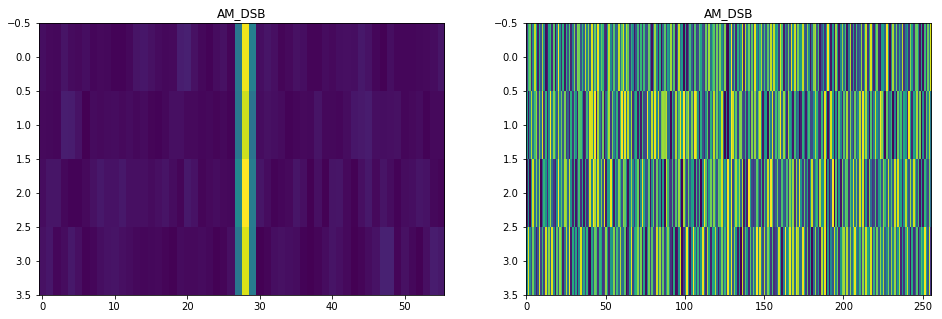

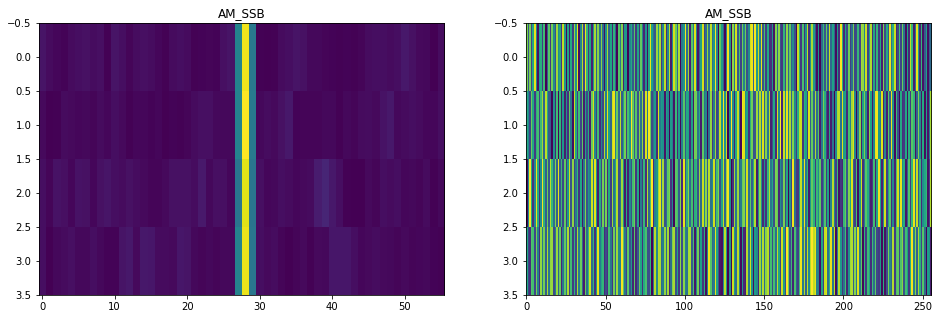

In [23]:
for modType in data.modTypes[:]:
    min_SNR = 6
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    print(cdata.shape,index)

    # setup inspect
    sample_rate = data.instance_shape[1]
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    window = 4
    fold = cdata.squeeze().reshape((window,1024//window))
    fold *= np.hamming(1024//window)
    ft = np.fft.fftshift(np.fft.fft(fold, axis=1))
    print(ft.shape)
    
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.title(modType)
    plt.imshow(np.abs(ft[:, 100:156]), aspect='auto')
    plt.subplot(122)
    plt.title(modType)
    plt.imshow(np.angle(ft),aspect='auto')
#     plt.colorbar()
plt.show()

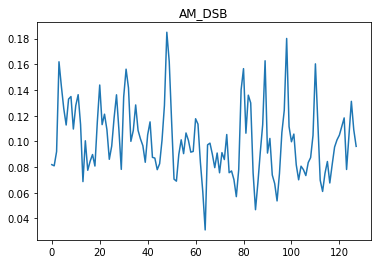

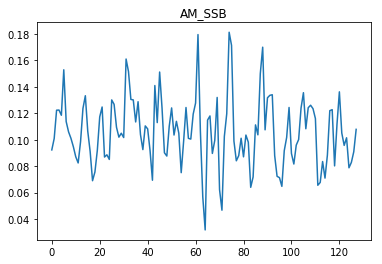

In [37]:
from scipy.signal import *
for modType in data.modTypes:
    min_SNR = 10
    max_SNR = 14
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    
    _, wel_spec = welch(cdata[0], window='hanning', nperseg=128, return_onesided=False, noverlap=100)
    wel_spec = np.fft.fftshift(wel_spec)
    
    
    plt.figure()
    plt.title(modType)
    plt.plot(wel_spec)
    #plt.plot(per_spec)
plt.show()

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


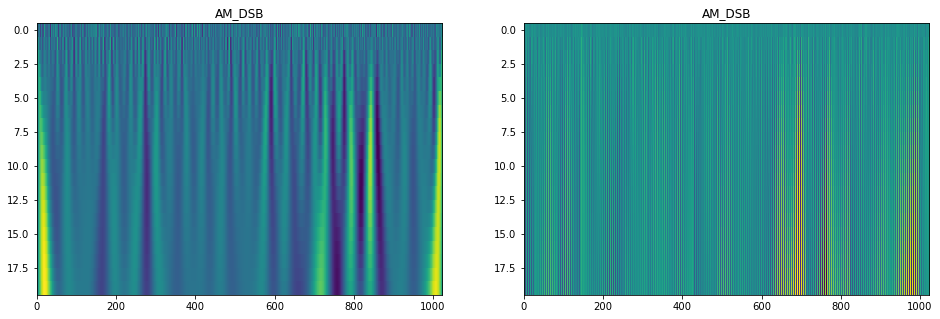

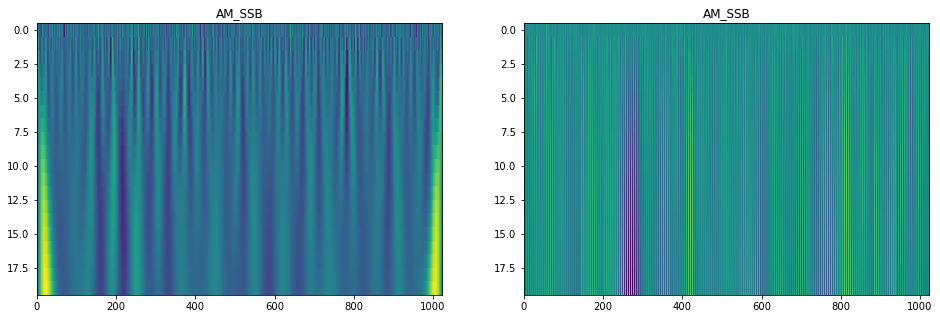

In [9]:
from scipy.signal import *
for modType in data.modTypes[:]:
    min_SNR = 6
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    
    widths = np.arange(1, 21)
    cwtricker = cwt(cdata[0], ricker, widths)
    cwtdaub = cwt(cdata[0], morlet, widths)
    
    
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.title(modType)
    plt.imshow(cwtricker, aspect='auto', interpolation='nearest')
    plt.subplot(122)
    plt.title(modType)
    plt.imshow(cwtdaub,aspect='auto', interpolation='nearest')
plt.show()


In [2]:
x_train, y_train, x_val, y_val = get_data(mode='welch', window='hamming', nperseg=512, noverlap=500,
                                          load_mods=['AM_DSB', 'AM_SSB'],
                                         BASEDIR='/home/mshefa/training_data/',
                                         files=[0])
#x_train = x_train[:100]
print(x_train.shape, x_val.shape)
# for i in range(5):
#     plt.figure()
#     plt.imshow(x_train[i,:,:,0], aspect='auto')
# plt.show()


[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 24000
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - Converting to numpy arrays...
[Data Loader] - Shuffling Data...
[Data Loader] - Splitting Data...
[Data Loader] - Train Size: 21600 Validation Size: 2400 Test Size: 0
[Data Loader] - Done.

(21600, 2, 1024)
(21600, 1024)


/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/scipy/signal/spectral.py:1623: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


(2400, 1024)
(21600, 256, 1) (2400, 256, 1)


In [11]:
x_train.shape


(21600, 256)

In [4]:

import os,random
import numpy as np
from keras.utils import np_utils
import keras.models
from keras.models import model_from_json, Sequential
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.recurrent import LSTM, GRU
from keras.backend import squeeze
from keras.regularizers import *
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from data_loader import *
from inception import *
import tensorflow as tf

input_img = Input(shape=(256,1))
x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_img)
#x = MaxPooling1D(pool_size=2)(x)
#x = LSTM(150, return_sequences=True)(x)
x = GRU(64, return_sequences=True)(x)
x = GRU(64)(x)
x = Dense(2, activation='sigmoid')(x)
model = Model(input_img, x)
model.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 256, 32)           128       
_________________________________________________________________
gru_1 (GRU)                  (None, 256, 64)           18624     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 43,650
Trainable params: 43,650
Non-trainable params: 0
_________________________________________________________________


In [5]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')
hist = model.fit(x_train, y_train,
          batch_size=32,
          nb_epoch=20,
          validation_data=[x_val, y_val],
          shuffle=True,
          verbose=1,
          callbacks=[lr_reducer, early_stopper])

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 21600 samples, validate on 2400 samples
Epoch 1/20
21568/21600 [============================>.] - ETA: 1s - loss: 0.6919 - acc: 0.5118

KeyboardInterrupt: 

In [14]:
from resnet2D import ResnetBuilder
img_channels, img_rows, img_cols, nclasses = 2, 1024, 20, 2
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nclasses)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1024, 20, 2)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 1024, 20, 64) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 1024, 20, 64) 256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 1024, 20, 64) 0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv2d_22 

In [15]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')
hist = model.fit(x_train, y_train,
          batch_size=32,
          nb_epoch=20,
          validation_data=[x_val, y_val],
          shuffle=True,
          verbose=1,
          callbacks=[lr_reducer, early_stopper])

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 21600 samples, validate on 2400 samples
Epoch 1/20
14432/21600 [===================>..........] - ETA: 2:04 - loss: 1.0654 - acc: 0.4965

KeyboardInterrupt: 

In [16]:
def func(a, transpose):
    a = np.sum(a, axis=1, keepdims=True)
    if transpose:
        a = np.transpose(a, (0,1))
    return a
_func = np.vectorize(func, excluded=['transpose'])
_func(np.arange(100).reshape(10,2,5), transpose=True)

AxisError: axis 1 is out of bounds for array of dimension 0

In [56]:
def cwt_ricker(x, widths):
    return cwt(x, ricker, widths)

my_cwt = np.vectorize(cwt_ricker, signature='(m),(n)->(n,m)')
x = np.random.random((1000,1024))

In [57]:
%timeit my_cwt(x, np.arange(1,21)).shape

2.65 s ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit [cwt(x[i], ricker, np.arange(1,21)) for i in range(x.shape[0])]

2.66 s ± 72.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
